In [1]:
# Import basic libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_utils import *
from implementations import *

In [2]:
# Define some paths
root = '../project1/'
data = os.path.join(root, 'Data/')
train_set_root = os.path.join(data, 'train.csv')
test_set_root = os.path.join(data, 'test.csv')
%ls data

sample-submission.csv  test.csv               train.csv


## Data preprocessing
#### Load datasets

In [3]:
data = pd.read_csv(train_set_root)
for col_name in data.columns:
     data.loc[data[col_name] == -999.0,col_name]= np.nan
# data = data.dropna(how='any', axis=0)
data.head(100)

,Id,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,100000.0,s,138.470,51.655,97.827,27.980,0.910,124.711,2.666,3.064,...,-0.277,258.733,2.0,67.435,2.150,0.444,46.062,1.240,-2.475,113.497
1,100001.0,b,160.937,68.768,103.235,48.146,NaN,NaN,NaN,3.473,...,-1.916,164.546,1.0,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,100002.0,b,NaN,162.172,125.953,35.635,NaN,NaN,NaN,3.148,...,-2.186,260.414,1.0,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
3,100003.0,b,143.905,81.417,80.943,0.414,NaN,NaN,NaN,3.310,...,0.060,86.062,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
4,100004.0,b,175.864,16.915,134.805,16.405,NaN,NaN,NaN,3.891,...,-0.871,53.131,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,100095.0,b,98.181,68.298,77.216,1.170,NaN,NaN,NaN,2.918,...,-3.011,52.207,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
96,100096.0,s,113.750,52.067,76.262,1.250,NaN,NaN,NaN,2.962,...,0.234,97.737,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000
97,100097.0,s,124.575,34.558,100.197,161.051,3.243,324.597,-2.626,1.479,...,-1.611,432.241,3.0,97.160,-1.686,2.858,42.808,1.557,1.534,171.763
98,100098.0,b,77.578,72.277,58.168,153.606,2.604,370.937,-1.597,0.988,...,1.565,351.780,2.0,111.656,-0.987,-0.035,92.256,1.617,-1.433,203.911


(array([99913.,     0.,     0., 77544.,     0.,     0., 50379.,     0.,
            0., 22164.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

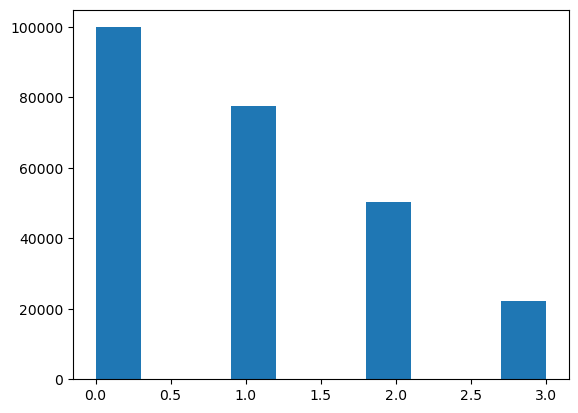

In [4]:
plt.hist(data['PRI_jet_num'])# data imbalance

## Begins here

In [25]:
train_data, train_label = load_data(train_set_root)
train_data = standardize(train_data)

In [23]:
x = train_data.copy()
feature_idx_dict = {0: [0, 1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21],
                        1: [0, 1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 29],
                        2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25,
                            26, 27, 28, 29]}
jetnum = 22

group0 = x[np.where(x[:, jetnum] == 0)]
group0_x = group0[:, feature_idx_dict[0]]

group1 = x[np.where(x[:, jetnum] == 1)]
group1_x = group1[:, feature_idx_dict[1]]

group2 = x[np.where(x[:, jetnum] >= 2)]
group2_x = group2[:, feature_idx_dict[2]]


In [24]:
group1

array([], shape=(0, 30), dtype=float64)

In [7]:
train_label

array([ 1., -1., -1., ...,  1., -1., -1.])

In [8]:
import data_utils
def cross_validation(train_data, train_label, k_fold, eval_func, input_dict):
  data_num = train_data.shape[0]
  data_dim = train_data.shape[1]
  fold_part_idx = data_utils.k_fold(data_num, k_fold)

  loss_list = []
  acc_list = []
  for k in range(k_fold):
    cur_train_idx = np.concatenate([fold_part_idx[:k, :], fold_part_idx[k+1:, :]], axis = 0)
    cur_train_idx = cur_train_idx.flatten()
    cur_test_idx = fold_part_idx[k, :]
    x_tr = train_data[cur_train_idx, :]
    x_te = train_data[cur_test_idx, :]
    y_tr = train_label[cur_train_idx]
    # print(np.sum(y_tr==1)/len(y_tr))
    y_te = train_label[cur_test_idx]

    lambda_ = input_dict.get('lambda_')
    initial_w = input_dict.get('initial_w')
    max_iters = input_dict.get('max_iters')
    gamma = input_dict.get('gamma')
    sgd = input_dict.get('sgd')
    func_type = input_dict.get('func_type')

    w, loss = eval_func(y_tr, x_tr, lambda_, initial_w, max_iters, gamma, sgd)
    _, train_acc = compute_statistics_all(y_tr, x_tr, w, func_type = input_dict['func_type'])
    test_loss, test_acc = compute_statistics_all(y_te, x_te, w, func_type = input_dict['func_type'])
    loss_list.append(test_loss)
    acc_list.append(test_acc)
  return np.mean(loss_list), np.mean(acc_list)

The cross validation part

## Test for the ```reg_logistic_regression```

In [9]:
lambdas = np.logspace(-10, 0, 10)
gammas = [0.015]
iters = [1000]
test_func = reg_logistic_regression
cleans = [0, 1]
polys = [1]
degrees = [9]
normalizes = [0, 1]
all_polys = [True, False]

In [10]:
def compute_statistics_all(y, tx, w, func_type='linear'):
    """Compute Loss and Accuracy after training.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy arrays of shape (2, ), final weight
        func_type: type of model used, linear for linear regression and logistic for logistic regression.

    Returns:
        loss: scalar
        acc: classification accuracy
    """
    data_num = y.shape[0]

    if (func_type == 'linear'):
        model_output = np.dot(tx, w)
        e_mat = y - model_output
        loss = 0.5 * np.dot(e_mat.T, e_mat) / data_num
        model_output[np.where(model_output > 0)] = 1
        model_output[np.where(model_output <= 0)] = -1
    elif (func_type == 'logistic'):
        model_output = sigmoid(np.dot(tx, w))
        loss = -np.dot(y, np.log(model_output + eps)) - np.dot((1 - y).T, np.log(1 - model_output + eps))
        model_output[np.where(model_output > 0.5)] = 1
        model_output[np.where(model_output <= 0.5)] = 0

    acc = np.sum(model_output == y) / data_num
    return loss, acc

In [11]:
k_fold_num = 5
group_num = 2

In [12]:
train_label_reg = train_label.copy()
train_label_reg[train_label_reg == -1] = 0

In [13]:
lambdas = np.logspace(-10, 0, 10)
gammas = [0.05]
max_iters = [1000]
test_func = reg_logistic_regression
cleans = [0, 1]
polys = [1]
degrees = [12,11,10,9,8]
normalizes = [0, 1]
all_polys = [True, False]

linear regression gd/sgd      try gamma try max_iter  try degree
ridge regression: lambda      try degree


In [ ]:
import warnings
warnings.filterwarnings("ignore")
num_iter_ = 0
group_num = 0
max_acc = 0
print(train_label_reg[:5])
for clean in cleans:
  for poly in polys:
    if poly:
      for gamma in gammas:
        for degree in degrees:
          degree_list = [1] * 3
          degree_list[group_num] = degree
          for normalize_ in normalizes:
            for all_poly in all_polys:
              group0_x, group0_labels, group1_x, group1_labels, group2_x, group2_labels = \
                            data_utils.process_data(train_data, train_label_reg, clean = clean)
              group0_x, group1_x, group2_x = \
                      data_utils.group_poly(group0_x, group1_x, group2_x, degree_list, all_poly)
              cur_group = [group0_x, group1_x, group2_x]
              cur_labels = [group0_labels, group1_labels, group2_labels]
              group_x = cur_group[group_num]
              group_label = cur_labels[group_num]
              if(normalize_):
                group_x = data_utils.normalize(group_x)

              input_dict = {'lambda_':0, \
                      'initial_w':np.zeros(group_x.shape[1]), \
                      'max_iters':8000, \
                      'gamma':gamma, \
                      'sgd':False, \
                      'func_type':'logistic'}
              loss, acc = cross_validation(group_x, group_label, k_fold_num, test_func, input_dict)
              print(f'For this combination scheme.\iter:{num_iter_} \
                    Clean:{clean}, \
                    Poly:{poly}, \
                    Degree:{degree}, \
                    Normalize: {normalize_}, \
                    all_poly:{all_poly}, \
                    Acc:{acc}, Gamma:{gamma}')
              if(acc > max_acc):
                print(f'Found a better scheme.\ iter:{num_iter_} \ Clean:{clean}, \
                    Poly:{poly}, \
                    Degree:{degree}, \
                    Normalize: {normalize_}, \
                    all_poly:{all_poly}, \
                    Acc:{acc}, Gamma:{gamma}')
                max_acc = acc
              num_iter_ = num_iter_ + 1
    else:
      for gamma in gammas:
        for normalize_ in normalizes:
          group0_x, group0_labels, group1_x, group1_labels, group2_x, group2_labels = \
                        data_utils.process_data(train_data, train_label_reg, clean = clean)
          cur_group = [group0_x, group1_x, group2_x]
          cur_labels = [group0_labels, group1_labels, group2_labels]
          group_x = cur_group[group_num]
          group_label = cur_labels[group_num]
          if(normalize_):
            group_x = data_utils.normalize(group_x)
          input_dict = {'lambda_':0, \
                  'initial_w':np.zeros(group_x.shape[1]), \
                  'max_iters':10000, \
                  'gamma':gamma, \
                  'sgd':False, \
                  'func_type':'logistic'}
          try:
            loss, acc = cross_validation(group_x, group_label, k_fold_num, test_func, input_dict)
          except:
            print(f'Wrong. \
                Clean:{clean}, \
                Poly:{poly}, \
                Normalize: {normalize_}')
            continue
          print(f'For this combination scheme.\iter:{num_iter_} \
                  Clean:{clean}, \
                  Poly:{poly}, \
                  Degree:{degree}, \
                  Normalize: {normalize_}, \
                  all_poly:{all_poly}, \
                  Acc:{acc}, Gamma:{gamma}')
          if(acc > max_acc):
            print(f'Found a better scheme. \iter:{num_iter_} \
                Clean:{clean}, \
                Poly:{poly}, \
                Normalize: {normalize_}, \
                Acc:{acc}, gamma:{gamma}')
            max_acc = acc
          num_iter_ = num_iter_ + 1